In [7]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data is contained in '../Data/Processed' directory
# This cell lists all files under the input directory

import os
INPUT_DIR = os.path.join(os.path.dirname(os.getcwd()), 'Data', 'Processed')
for dirname, _, filenames in os.walk(INPUT_DIR):
    for filename in filenames:
        print(os.path.join(dirname, filename))

c:\Users\ASUS\Documents\Python Programming\Book recommendations\Data\Processed\Books_valid_ISBN_known_year_no_images.csv
c:\Users\ASUS\Documents\Python Programming\Book recommendations\Data\Processed\popular_books_with_descriptions.csv
c:\Users\ASUS\Documents\Python Programming\Book recommendations\Data\Processed\ratings_for_popular_books.csv
c:\Users\ASUS\Documents\Python Programming\Book recommendations\Data\Processed\Ratings_valid_ISBN.csv
c:\Users\ASUS\Documents\Python Programming\Book recommendations\Data\Processed\users_valid_age_with_country.csv


This notebook gives non-personalized book recommendations. This is useful to deal with cold-start problem, if we need to give recommendations to a user who didn't review much. 

First, we load the ratings dataframe.

In [8]:
ratings_df = pd.read_csv(os.path.join(INPUT_DIR, 'Ratings_valid_ISBN.csv'))
print(ratings_df.head())

   User-ID        ISBN  Book-Rating
0   276725  034545104X            0
1   276726  0155061224            5
2   276727  0446520802            0
3   276729  052165615X            3
4   276729  0521795028            6


 We will not consider implicit ratings here, so we will get rid of rows with rating zero.

In [9]:
ratings_df = ratings_df[ratings_df['Book-Rating'] != 0]
print(ratings_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 427473 entries, 1 to 1136187
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   User-ID      427473 non-null  int64 
 1   ISBN         427473 non-null  object
 2   Book-Rating  427473 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 13.0+ MB
None


A reasonable thing to recommend to someone is a popular book with a high enough rating. So, the first step will be to look at how many reviews does each book have. For every ISBN we count how many reviews we have.

In [10]:
books_popularity = ratings_df['ISBN'].value_counts()
print(books_popularity)

0316666343    707
0971880107    581
0385504209    487
0312195516    383
0679781587    333
             ... 
0871231824      1
0849917077      1
0830714855      1
0816722919      1
0806917695      1
Name: ISBN, Length: 180450, dtype: int64


We got some numbers but ISBN does not tell us much. Let us retrieve the titles from the book csv file, so that we could check that the most reviewed books are something we heard about.

In [11]:
books_df = pd.read_csv(os.path.join(INPUT_DIR, 'Books_valid_ISBN_known_year_no_images.csv'))
print(books_df.head())

         ISBN                                         Book-Title  \
0  0195153448                                Classical Mythology   
1  0002005018                                       Clara Callan   
2  0060973129                               Decision in Normandy   
3  0374157065  Flu: The Story of the Great Influenza Pandemic...   
4  0393045218                             The Mummies of Urumchi   

            Book-Author  Year-Of-Publication                   Publisher  
0    Mark P. O. Morford               2002.0     Oxford University Press  
1  Richard Bruce Wright               2001.0       HarperFlamingo Canada  
2          Carlo D'Este               1991.0             HarperPerennial  
3      Gina Bari Kolata               1999.0        Farrar Straus Giroux  
4       E. J. W. Barber               1999.0  W. W. Norton &amp; Company  


Since ISBN is unique, let us make ISBN the index for the books dataframe.

In [12]:
books_df = books_df.set_index('ISBN')
print(books_df.head())

                                                   Book-Title  \
ISBN                                                            
0195153448                                Classical Mythology   
0002005018                                       Clara Callan   
0060973129                               Decision in Normandy   
0374157065  Flu: The Story of the Great Influenza Pandemic...   
0393045218                             The Mummies of Urumchi   

                     Book-Author  Year-Of-Publication  \
ISBN                                                    
0195153448    Mark P. O. Morford               2002.0   
0002005018  Richard Bruce Wright               2001.0   
0060973129          Carlo D'Este               1991.0   
0374157065      Gina Bari Kolata               1999.0   
0393045218       E. J. W. Barber               1999.0   

                             Publisher  
ISBN                                    
0195153448     Oxford University Press  
0002005018       Harp

Now we will add the title to the ratings dataframe.

In [13]:
ratings_df['Title']=ratings_df['ISBN'].apply(lambda x: np.nan if x not in books_df.index else books_df['Book-Title'][x])
print(ratings_df)

         User-ID        ISBN  Book-Rating  \
1         276726  0155061224            5   
3         276729  052165615X            3   
4         276729  0521795028            6   
6         276736  3257224281            8   
7         276737  0600570967            6   
...          ...         ...          ...   
1136180   276704  0743211383            7   
1136182   276704  0806917695            5   
1136184   276704  1563526298            9   
1136186   276709  0515107662           10   
1136187   276721  0590442449           10   

                                                     Title  
1                                         Rites of Passage  
3                                           Help!: Level 1  
4        The Amsterdam Connection : Level 4 (Cambridge ...  
6                                                      NaN  
7                                                      NaN  
...                                                    ...  
1136180                         

In [14]:
print(ratings_df['Title'].isna().sum())

49484


It seems that quite a lot of books are missing information about them - we could not find a title for around 1/8 of our reviews! Let us look at the most popular books, though, hopefully, at least they have a title. 

In [15]:
def str_book_info(isbn):
    """Takes book's ISBN and returns a string containing the title and the author of the book 
    if it is in the database 
    or '!!!Book with no info (ISBN:isbn)' if there is no such ISBN in the database"""
    if isbn not in books_df.index:
        return "!!!Book with no info (ISBN:"+isbn+")"
    else:    
        return str(books_df['Book-Title'][isbn])+" by "+str(books_df['Book-Author'][isbn])

In [16]:
for isbn, reviews in books_popularity.head(20).items():
    print(str_book_info(isbn)+" has "+str(reviews)+" reviews.")

The Lovely Bones: A Novel by Alice Sebold has 707 reviews.
Wild Animus by Rich Shapero has 581 reviews.
The Da Vinci Code by Dan Brown has 487 reviews.
The Red Tent (Bestselling Backlist) by Anita Diamant has 383 reviews.
!!!Book with no info (ISBN:0679781587) has 333 reviews.
Divine Secrets of the Ya-Ya Sisterhood: A Novel by Rebecca Wells has 320 reviews.
Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback)) by J. K. Rowling has 313 reviews.
The Secret Life of Bees by Sue Monk Kidd has 307 reviews.
Where the Heart Is (Oprah's Book Club (Paperback)) by Billie Letts has 295 reviews.
A Painted House by John Grisham has 281 reviews.
Girl with a Pearl Earring by Tracy Chevalier has 278 reviews.
The Pilot's Wife : A Novel by Anita Shreve has 272 reviews.
Angels &amp; Demons by Dan Brown has 269 reviews.
Snow Falling on Cedars by David Guterson has 256 reviews.
The Catcher in the Rye by J.D. Salinger has 243 reviews.
The Five People You Meet in Heaven by Mitch Albom has 242 revie

Most of these books I've heard about and they are quite well-known so our popularity list seems to be okay. Quick googling reveals that the only book without info in the books dataframe that made it to the top-20 is "Memoirs of a Geisha", also a well-known novel. The only weird one (at least to me) is "Wild Animus", I have never heard of it. It seems it is a self-published book and the author has spent an awful lot of money on publishing it (read [this](https://litreactor.com/columns/what-the-hell-is-wild-animus), for example). 

Now let us look at the average rating of each book.

In [17]:
avg_rating_df = ratings_df[["ISBN", "Book-Rating"]].groupby(["ISBN"]).mean()
print(avg_rating_df.head())

               Book-Rating
ISBN                      
000000000         3.500000
0000000000        7.600000
0000000000000     7.666667
0000000016964     7.000000
0000000022057     3.000000


Let us now sort the books by rating and again look at the top 20.

In [18]:
sorted_avg_rating_df = avg_rating_df.sort_values(by="Book-Rating", ascending=False)
for isbn, rating in sorted_avg_rating_df.head(20).iterrows():
    print(str_book_info(isbn)+" has an average rating of "+str(sorted_avg_rating_df['Book-Rating'][isbn]))

!!!Book with no info (ISBN:0553130137) has an average rating of 10.0
Just Give Me Jesus by Anne Graham Lotz has an average rating of 10.0
Alexander Solzhenitsyn: A Century in His Life by D. M. Thomas has an average rating of 10.0
The Xenophobe's Guide to the Poles by Ewa Lipniacka has an average rating of 10.0
The Xenophobe's Guide to the Swedes by Peter Berlin has an average rating of 10.0
Science Fiction by John Clute has an average rating of 10.0
Royal Horticultural Society Encyclopedia of Herbs and Their Uses (RHS) by Deni Bown has an average rating of 10.0
The Xenophobe's Guide to the Swiss by Paul Bilton has an average rating of 10.0
The Xenophobe's Guide to the Welsh by John Winterson Richards has an average rating of 10.0
!!!Book with no info (ISBN:345330909X) has an average rating of 10.0
Flamboyant by Elizabeth Swados has an average rating of 10.0
Herbs for Health and Healing: A Drug-Free Guide to Prevention and Cure by Kathi Keville has an average rating of 10.0
The Tribes o

All the top books have an average rating of 10.0, which probably means that they do not have many reviews. Let us only consider the books with at least 50 reviews.

In [19]:
books_with_many_reviews = books_popularity[books_popularity >= 50].index
print(books_with_many_reviews)

Index(['0316666343', '0971880107', '0385504209', '0312195516', '0679781587',
       '0060928336', '059035342X', '0142001740', '0446672211', '044023722X',
       ...
       '0553582526', '051513628X', '1844262553', '0743224574', '0345384369',
       '0375760911', '0679723161', '0671894455', '0446611808', '0515136379'],
      dtype='object', length=537)


We got 537 books. Let us create a dataframe with ratings only for these books and sort them by average rating. The top 10 books will be our non-personalized recommendation to a new user.

In [20]:
popular_books_ratings_df = ratings_df[ratings_df['ISBN'].isin(books_with_many_reviews)]
print(popular_books_ratings_df.head())

    User-ID        ISBN  Book-Rating  \
8    276744  038550120X            7   
27   276754  0684867621            8   
28   276755  0451166892            5   
80   276788  043935806X            7   
82   276796  0330332775            5   

                                                Title  
8                                     A Painted House  
27            The Girl Who Loved Tom Gordon : A Novel  
28                           The Pillars of the Earth  
80  Harry Potter and the Order of the Phoenix (Boo...  
82                              Bridget Jones's Diary  


In [21]:
popular_books_avgs = popular_books_ratings_df[["ISBN", "Book-Rating"]].groupby('ISBN').mean().sort_values(by="Book-Rating", ascending=False)
for isbn, rating in popular_books_avgs.head(20).iterrows():
    print(str_book_info(isbn)+" has an average rating of "+str(sorted_avg_rating_df['Book-Rating'][isbn]))

The Return of the King (The Lord of the Rings, Part 3) by J.R.R. TOLKIEN has an average rating of 9.402597402597403
Harry Potter and the Goblet of Fire (Book 4) by J. K. Rowling has an average rating of 9.262773722627736
Harry Potter and the Sorcerer's Stone (Book 1) by J. K. Rowling has an average rating of 9.20754716981132
The Two Towers (The Lord of the Rings, Part 2) by J.R.R. TOLKIEN has an average rating of 9.120481927710843
Harry Potter and the Prisoner of Azkaban (Book 3) by J. K. Rowling has an average rating of 9.082706766917294
Charlotte's Web (Trophy Newbery) by E. B. White has an average rating of 9.073529411764707
Harry Potter and the Prisoner of Azkaban (Book 3) by J. K. Rowling has an average rating of 9.035460992907801
Harry Potter and the Order of the Phoenix (Book 5) by J. K. Rowling has an average rating of 9.033980582524272
Harry Potter and the Sorcerer's Stone (Book 1) by J. K. Rowling has an average rating of 8.983193277310924
The Little Prince by Antoine de Sain

Now, this list of books makes perfect sense, all of the titles in it are famous, well-liked by many people. 

Another type of non-personalized suggestions we could do is the thing everyone probably encountered on Amazon - the "people who bought X also bought Y". We will look for how often a pair of books was reviewed by the same person.

For every person we are going to take the list of books they reviewed and add all possible pairs of books reviewed by that person in a dataframe. We will only take books that users loved, that is, with a rating of 10 out of 10.

In [22]:
positive_ratings_df = ratings_df[ratings_df['Book-Rating']==10]
print(positive_ratings_df.head())
print(positive_ratings_df.info())

     User-ID        ISBN  Book-Rating  \
29    276760  8440682697           10   
57    276772  3499230933           10   
58    276772  3596151465           10   
81    276788  055310666X           10   
108   276808  0395547032           10   

                                                 Title  
29                                                 NaN  
57                                 Adressat unbekannt.  
58                                     Henry der Held.  
81                                        False Memory  
108  Richard Brautigan : A Confederate General from...  
<class 'pandas.core.frame.DataFrame'>
Int64Index: 77541 entries, 29 to 1136187
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   User-ID      77541 non-null  int64 
 1   ISBN         77541 non-null  object
 2   Book-Rating  77541 non-null  int64 
 3   Title        70215 non-null  object
dtypes: int64(2), object(2)
memory usage: 3.0+ MB
None

Now, we write a function that takes a list of books (actually, it will be a groupby object, not a list) and creates a dataframe containing all pairs of that books.

In [23]:
from itertools import permutations

def create_pairs(x):
    """Takes Series x and returns a DataFrame containing all pairs of the values in x"""
    pairs = pd.DataFrame(list(permutations(x.values, 2)), columns=['book_1','book_2'])
    return pairs

In [24]:
book_pairs = positive_ratings_df.groupby('User-ID')['ISBN'].apply(create_pairs)
print(book_pairs.info())
print(book_pairs.head())

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 8044332 entries, (99, 0) to (278832, 5)
Data columns (total 2 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   book_1  object
 1   book_2  object
dtypes: object(2)
memory usage: 249.1+ MB
None
               book_1      book_2
User-ID                          
99      0  0446677450  0671621009
        1  0671621009  0446677450
183     0  8497890663  9726080630
        1  8497890663  9728487002
        2  8497890663  9728487142


It remains to choose the pairs that are most common.

In [25]:
pairs_counted = book_pairs.groupby(['book_1', 'book_2']).size()
pairs_counted_df = pairs_counted.to_frame(name='size').reset_index()
print(pairs_counted_df.head())

       book_1      book_2  size
0  0000000000  8422698250     1
1  0000000000  8422698293     1
2  0000000000  8422698315     1
3  0000000000  8478884459     1
4  0000000000  8478884955     1


In [26]:
pairs_counted_df_sorted = pairs_counted_df.sort_values(by='size', ascending=False)

To give a recommendation to the reader for a certain book, we just need to filter our dataframe by its ISBN. For example, if someone reviewed Harry Potter and the Order of the Phoenix (Book 5) by J. K. Rowling, which has ISBN 043935806X, we can recommend to that reader the following books:

In [27]:
recommendations = pairs_counted_df_sorted[pairs_counted_df_sorted['book_1'] == '043935806X']
print(recommendations.head(10))
for _, isbn in recommendations['book_2'].head(10).iteritems():
    print(books_df['Book-Title'][isbn])

             book_1      book_2  size
2910221  043935806X  0439139597    37
2910219  043935806X  0439136350    30
2910211  043935806X  0439064864    26
2910809  043935806X  0590353403    24
2910810  043935806X  059035342X    18
2910220  043935806X  0439136369    16
2910222  043935806X  0439139600    14
2910212  043935806X  0439064872    11
2909770  043935806X  0345339703     5
2909772  043935806X  0345339738     5
Harry Potter and the Goblet of Fire (Book 4)
Harry Potter and the Prisoner of Azkaban (Book 3)
Harry Potter and the Chamber of Secrets (Book 2)
Harry Potter and the Sorcerer's Stone (Book 1)
Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))
Harry Potter and the Prisoner of Azkaban (Book 3)
Harry Potter and the Goblet of Fire (Book 4)
Harry Potter and the Chamber of Secrets (Book 2)
The Fellowship of the Ring (The Lord of the Rings, Part 1)
The Return of the King (The Lord of the Rings, Part 3)


The list of books seems to be connected with the original book, but for a specific user we will need to cut from recommendations all the books that the user has already reviewed. For example, if the person has read the 5th book about Harry Potter, they probably have already read the previous 4 (but if they didn't, they definitely should and they will receive our recommendation!).

Let us now try to recommend something to a user who wrote the most reviews. First, we group our ratings by User-ID to find that user.

In [28]:
reviews_counted_df = ratings_df.groupby('User-ID').size().to_frame(name='size')
print(reviews_counted_df.head())

         size
User-ID      
8           7
9           1
10          1
12          1
14          3


In [29]:
user_with_most_reviews = reviews_counted_df.idxmax()['size']
print(user_with_most_reviews)
print(reviews_counted_df.loc[user_with_most_reviews])

11676
size    8328
Name: 11676, dtype: int64


So, the user 11676 has left the most amount of reviews, 8328. Let us create a dataframe of this user's reviews.

In [30]:
reviews_of_our_user = ratings_df[ratings_df['User-ID'] == user_with_most_reviews][['ISBN', 'Book-Rating']]
print(reviews_of_our_user.head())
print(reviews_of_our_user.info())

             ISBN  Book-Rating
44732  0000000000            9
44733  0001055666            9
44739  0001944711            6
44740  0002005018            8
44741  0002118580            9
<class 'pandas.core.frame.DataFrame'>
Int64Index: 8328 entries, 44732 to 58047
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ISBN         8328 non-null   object
 1   Book-Rating  8328 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 195.2+ KB
None


Let us check what kind of ratings our user gives. We will plot a histogram for that.

<AxesSubplot:>

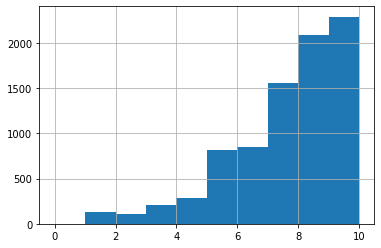

In [31]:
reviews_of_our_user['Book-Rating'].hist(bins=range(11))

We will try to search for recommendations based on the books our user liked a lot, that is, the books the user gave at least a 8 out of 10 rating. We will go over those books and create a list of books that are often read with them. We won't include books that our user has already reviewed.

In [32]:
frames = []
pairs_with_new_books = pairs_counted_df_sorted[['book_1', 'book_2', 'size']][~pairs_counted_df_sorted['book_2'].isin(list(reviews_of_our_user['ISBN']))] 
for ind, row in reviews_of_our_user[reviews_of_our_user['Book-Rating'] >= 8].iterrows():
    possible_books = pairs_with_new_books[(pairs_with_new_books['book_1'] == row['ISBN'])]
    frames.append(possible_books)
    #print(ind-44732)
recommendations_df = pd.concat(frames)
print(recommendations_df.info())
print(recommendations_df.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 277574 entries, 0 to 8012273
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   book_1  277574 non-null  object
 1   book_2  277574 non-null  object
 2   size    277574 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 8.5+ MB
None
       book_1      book_2  size
0  0000000000  8422698250     1
6  0000000000  8478886451     1
5  0000000000  8478885196     1
4  0000000000  8478884955     1
3  0000000000  8478884459     1


In [33]:
recommendations_df = recommendations_df.drop(columns='book_1')
print(recommendations_df.head())

       book_2  size
0  8422698250     1
6  8478886451     1
5  8478885196     1
4  8478884955     1
3  8478884459     1


In [34]:
print(recommendations_df.groupby('book_2').sum())

            size
book_2          
000105337X     1
0001821326     2
0001845039    16
0001911619     2
0001935968     7
...          ...
9997412044     8
9997412958     2
9997508769    14
9997512952     2
9998914140    12

[27458 rows x 1 columns]


In [35]:
sorted_recommendations_df = recommendations_df.groupby('book_2').sum().sort_values(by='size', ascending=False)
print(sorted_recommendations_df.head())

            size
book_2          
043935806X   423
0439136350   354
0679781587   200
0446310786   193
0440211727   168


Now let us print the top 10 recommended books for our user.

In [36]:
for isbn, _ in sorted_recommendations_df.head(10).iterrows():
    print(str_book_info(isbn))

Harry Potter and the Order of the Phoenix (Book 5) by J. K. Rowling
Harry Potter and the Prisoner of Azkaban (Book 3) by J. K. Rowling
!!!Book with no info (ISBN:0679781587)
To Kill a Mockingbird by Harper Lee
A Time to Kill by JOHN GRISHAM
Birthright by Nora Roberts
The Hobbit : The Enchanting Prelude to The Lord of the Rings by J.R.R. TOLKIEN
Red Dragon by Thomas Harris
Seven Up (A Stephanie Plum Novel) by Janet Evanovich
Dance upon the Air (Three Sisters Island Trilogy) by Nora Roberts
